In [ ]:
#| default_exp data

# Sanity check

> Before jumping into training models with the data, it's a good practice to check the health of the data we are going to be working with.

## Distribution of labels per patient

As we saw while we were loading the data, there might be some recordings that don't have the full set of labels we are interested in. To account for this, we are going to obtain the label distribution per recording to be able to differentiate between fully labelled recordings and non-fully labelled recordings. 

When going further in our analysis, it can be important to filter out the non-fully labelled recordings, at least, until we have a full working pipeline we are happy with.

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#| hide
path_data = "/media/2tbraid/antonia/PSG/"

In [ ]:
#| export
import os
from glob import glob
from collections import Counter
from typing import List, Dict

from rich.progress import track
import numpy as np
import pandas as pd
import mne
import yasa

from sleepstagingidal.data import *

The steps we have to follow are:

- Load the raw `.edf` file.
- Extract transform the `Annotations` into `Events` and filter them using regex.

In [ ]:
path_files = glob(os.path.join(path_data, "*.edf"))

In [ ]:
raw = mne.io.read_raw_edf(path_files[0], preload=False)

Extracting EDF parameters from /media/2tbraid/antonia/PSG/PSG29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [ ]:
events, events_id = mne.events_from_annotations(raw, regexp='Sleep stage [A-Z]\d*')

Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage W']


When obtaining events from annotations, the annotations are encoded in sparse notation. To ease our analysis we can define a couple of functions to turn them back easily into human readable format again:

In [ ]:
#| exporti

def swap_dict(dictionary: Dict # dictionary to be swapped,
              ) -> Dict: # Swapped dictionary
    """Turns the keys into values and the values into keys."""
    return {value:key for key, value in dictionary.items()}

In [ ]:
show_doc(swap_dict)

---

### swap_dict

>      swap_dict (dictionary:Dict)

Turns the keys into values and the values into keys.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| dictionary | typing.Dict | dictionary to be swapped, |
| **Returns** | **typing.Dict** | **Swapped dictionary** |

In [ ]:
#| export
def map_events(events, # events array obtained from `mne.events_from_annotations()`.
               mapping: Dict, # dictionary mapping from encoded annotations to readable.
               ) -> List[str]: # mapped events in human readable format.
    """Turns an encoded representation of the annotations into a human readable one using the corresponding mapping dictionary"""
    mapped_events = [mapping[event] for event in events[:,-1]]
    return mapped_events

In [ ]:
assert len(events[:,-1]) == len(map_events(events, swap_dict(events_id)))

To wrap it up, let's define a function that takes as input a path to a file and outputs its event annotations in human readable form:

In [ ]:
#| export
def get_sleep_stages(path: str, # Path to an `.edf` file.
                     verbose: bool = False, # Amount of information shown when loading the file.
                     ) -> List[str]: # annotations in human readable form.
    """Loads an `.edf` file and extracts the sleep stage labels in human readable form."""
    raw = mne.io.read_raw_edf(path, preload=False, verbose=verbose)
    events, events_id = mne.events_from_annotations(raw, regexp='Sleep stage [A-Z]\d*', verbose=verbose)
    return map_events(events, swap_dict(events_id))

In [ ]:
sleep_stages = get_sleep_stages(path_files[0])
assert len(sleep_stages) == len(events[:,-1])

Once we have all the interest labels from a file extracted, we can use a `Counter` to obtain its distribution:

In [ ]:
Counter(sleep_stages)

Counter({'Sleep stage W': 367, 'Sleep stage N1': 29, 'Sleep stage N2': 323})

## Amount of sleep stages per patient

The main thing we want to check is the amount of different labels that are present in each file: We expect each file to have 5 sleep stages (W, N1, N2, N3, R). This will be an easy thing to obtain using the functions we have previously defined:

In [ ]:
path_files[0].split("/")[-1]

'PSG29.edf'

In [ ]:
#| output false
all_sleep_stages = {}
for path_file in track(path_files):
    file = path_file.split("/")[-1]
    sleep_stages = get_sleep_stages(path_file)
    all_sleep_stages[file] = sleep_stages

Output()

Now that we have all the stages per recording, we can obtain:

- Quantity of stages per recording.
- Number of different stages per recording.

In [ ]:
all_quantity = {file:len(stages) for file, stages in all_sleep_stages.items()}

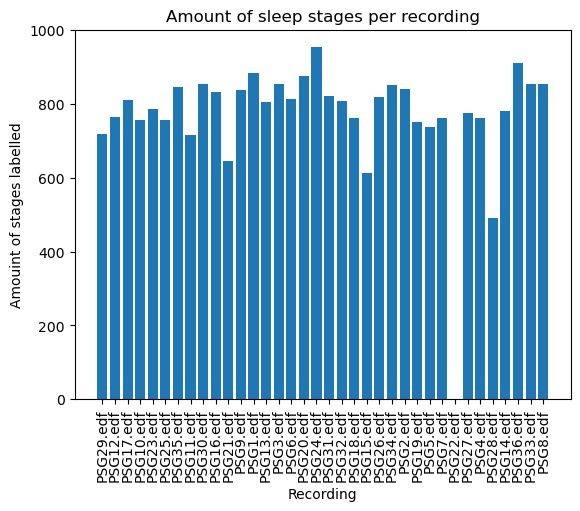

In [ ]:
plt.figure()
plt.bar(all_quantity.keys(), all_quantity.values())
plt.xticks(rotation=90)
plt.title("Amount of sleep stages per recording")
plt.xlabel("Recording")
plt.ylabel("Amouint of stages labelled")
plt.show()

In [ ]:
all_different = {file:len(set(stages)) for file, stages in all_sleep_stages.items()}

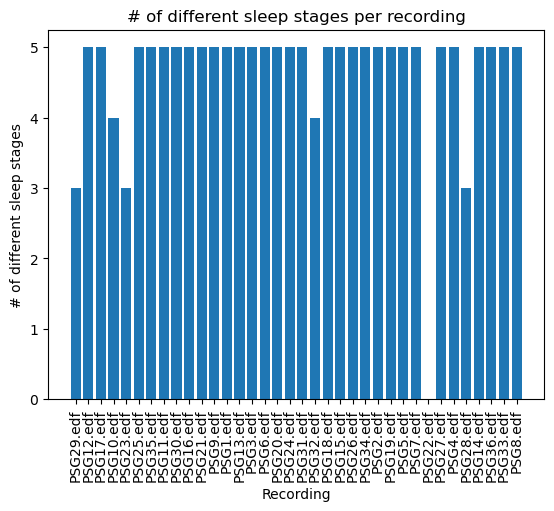

In [ ]:
plt.figure()
plt.bar(all_different.keys(), all_different.values())
plt.xticks(rotation=90)
plt.title("# of different sleep stages per recording")
plt.xlabel("Recording")
plt.ylabel("# of different sleep stages")
plt.show()

## Summing up

Thanks to this easy and quick exploration we have been able to recognize that the file `PSG22.edf` might have a problem because no stages are shown, and that files `PSG29.edf`, `PSG10.edf`, `PSG23.edf`, `PSG32.edf` and `PSG28.edf` might be problematic because they are missing some of the labels we are interested in. We can end this by creating a, for example, `.csv` file indicating the files that are completed and the ones that are not, so that we can choose which to load depending on what analysis we want to perform on our data.

In [ ]:
df = pd.DataFrame.from_dict(all_different, orient='index', columns=['DifferentStages'])
df.index.set_names("File", inplace=True)
df["Complete"] = df.DifferentStages == 5
df.head()

,DifferentStages,Complete
File,,
PSG29.edf,3,False
PSG12.edf,5,True
PSG17.edf,5,True
PSG10.edf,4,False
PSG23.edf,3,False


In [ ]:
df.to_csv("info.csv")